In [ ]:
#installing pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 54.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=10e1a774351172ba87d07426b3be58de6647d1536f90f290bc940ac84213de95
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Get the link for the google drive folder
file_list = drive.ListFile({'q': "'1BJX-pjCzirtxIiZeLD6UPDqq8va-oCc7' in parents"}).GetList()
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))

title: B00896278_joshuaBandiola.docx, id: 10sPxO5IIGtImYg34LM93OPuEQ0GXmgCF
title: datasetUnique.csv, id: 14WP2dFVGusb5AVfnWuX7izjCJ4WYejuf
title: Coursework_Set_Exercise_Student_Worksheet (1).ipynb, id: 1H2idatAmwh1ebtEnGIN25D9kpQ2Z3-a2


In [ ]:
#get the link for the document from google drive
id='14WP2dFVGusb5AVfnWuX7izjCJ4WYejuf'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('datasetUnique.csv')

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.fpm import FPGrowth

from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import sum, col, desc

import random

In [ ]:
#initialise spark context

# create the session
spark_session = SparkSession.builder.master('local[*]').getOrCreate()

In [ ]:
spark_session

In [ ]:
#load the dataset using pyspark
SparkDF = spark_session.read.csv('datasetUnique.csv', header=True, inferSchema=True)
SparkDF.show()

+----+--------------------+---+-------------+
|user|              artist|sex|      country|
+----+--------------------+---+-------------+
|   1|red hot chili pep...|  f|      Germany|
|   1|the black dahlia ...|  f|      Germany|
|   1|           goldfrapp|  f|      Germany|
|   1|    dropkick murphys|  f|      Germany|
|   1|            le tigre|  f|      Germany|
|   1|          schandmaul|  f|      Germany|
|   1|               edguy|  f|      Germany|
|   1|        jack johnson|  f|      Germany|
|   1|           eluveitie|  f|      Germany|
|   1|         the killers|  f|      Germany|
|   1|        judas priest|  f|      Germany|
|   1|          rob zombie|  f|      Germany|
|   1|          john mayer|  f|      Germany|
|   1|             the who|  f|      Germany|
|   1|          guano apes|  f|      Germany|
|   1|  the rolling stones|  f|      Germany|
|   3|    devendra banhart|  m|United States|
|   3|    boards of canada|  m|United States|
|   3|           cocorosie|  m|Uni

1) Identify and describe the number of columns and rows in the file.

In [ ]:
#using count to retrieve how many rows and len(columns) to retrieve how many columns in this dataset
print((SparkDF.count(), len(SparkDF.columns)), "\n")

#identify the columns in the dataset
print(SparkDF.columns, "\n")

#check if there's null values
SparkDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in SparkDF.columns] ).show()

SparkDF.printSchema()

(289955, 4) 

['user', 'artist', 'sex', 'country'] 

+----+------+---+-------+
|user|artist|sex|country|
+----+------+---+-------+
|   0|     0|  0|      0|
+----+------+---+-------+

root
 |-- user: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)



In [ ]:
#check how many users there are in the dataset
users = SparkDF.groupby(['user']).count()
print(f"The number of users: {users.count()}")

The number of users: 15000


2) Carry out exploratory data analysis using only PySpark. Use charts and plots to extract relevant
information about the dataset. For example, country-wise or artist-wise distribution of data

In [ ]:
#Since there are multiple instances belonging to one user, need to group rows belonging to that
#specific user and aggregate all the listed artists into one

GroupedDF = SparkDF.groupby("user").agg(collect_set(("artist")).alias("artist"), first("sex").alias("sex"), first("country").alias("country"))

GroupedDF.show(5)

# using groupby. First group on the user column and merge the artist matching the user together into a single list using agg and collect_set
# using first() to return the other columns. alias() to rename the columns
# collect_set de-dupes the data and return unique values

+----+--------------------+---+-------------+
|user|              artist|sex|      country|
+----+--------------------+---+-------------+
|   1|[the who, eluveit...|  f|      Germany|
|   3|[the flashbulb, m...|  m|United States|
|   5|[iron maiden, dre...|  m|      Finland|
|   6|[the streets, sig...|  m|     Portugal|
|   9|[meshuggah, finnt...|  m|United States|
+----+--------------------+---+-------------+
only showing top 5 rows



In [ ]:
#check if there are duplicated users
print(f"Distinct users: {GroupedDF.select(countDistinct('user')).show()}")

+--------------------+
|count(DISTINCT user)|
+--------------------+
|               15000|
+--------------------+

Distinct users: None


                  artist  count
0              radiohead   2704
1            the beatles   2668
2               coldplay   2378
3  red hot chili peppers   1786
4                   muse   1711
5              metallica   1670
6             pink floyd   1574
7            the killers   1473
8            linkin park   1473
9                nirvana   1473


<Figure size 3600x2880 with 0 Axes>

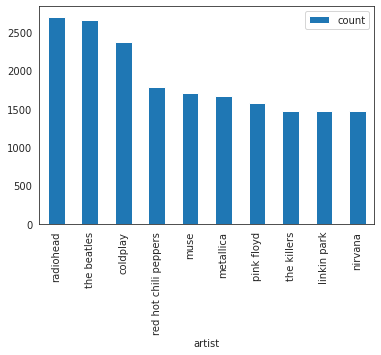

In [ ]:
#exploratory data analysis on most frequently played artists in the dataset

art = SparkDF.groupby(['artist']).count().sort(desc('count')).toPandas()
print(art.head(10))

#some visualisation on the data found above
plt.figure(figsize=(50,40))
art.head(10).plot(kind="bar", x="artist", y="count")
plt.show()

#### Radio head is the most played artist with 2704 users

##By using .sort(desc()), you can sort DataFrame in descending order
##groupby() function is used to split the data into groups based on some criteria

              country  count
0       United States   2905
1             Germany   1257
2      United Kingdom   1256
3              Poland    983
4  Russian Federation    785
5              Brazil    630
6              Sweden    575
7             Finland    510
8               Spain    506
9         Netherlands    467


<Figure size 3600x2880 with 0 Axes>

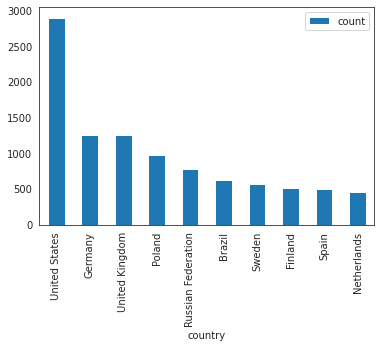

In [ ]:
#exploratory data analysis on most frequently played country

#using the 'groupedDF' dataframe to count the most frequently played countries
country = GroupedDF.groupby(['country']).count().sort(desc('count')).toPandas()
print(country.head(10))

plt.figure(figsize=(50,40))
country.head(10).plot(kind="bar", x="country", y="count")
plt.show()

#### united states is the most played country

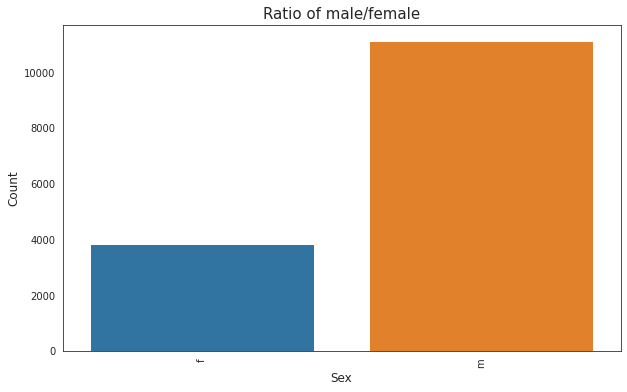

In [ ]:
#exploratory data analysis to check the ratio on male/female users

plt.figure(figsize=(10,6))
sns.countplot(x='sex', data=GroupedDF.toPandas())
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sex', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Ratio of male/female', fontsize=15)
plt.show()

#### more male listeners than female

                  artist  count
0              radiohead   1982
1            the beatles   1908
2               coldplay   1580
3              metallica   1424
4  red hot chili peppers   1344
5             pink floyd   1272
6                   muse   1150
7                nirvana   1123
8       system of a down   1092
9            linkin park   1090


<Figure size 3600x2880 with 0 Axes>

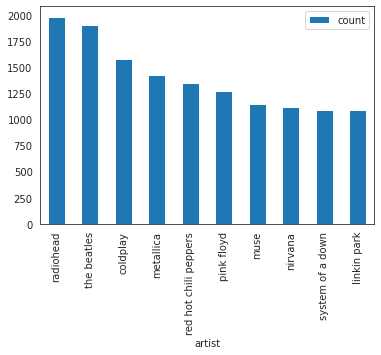

In [ ]:
#exploratory data analysis to check the most frequently played artists by male

male = SparkDF.filter(SparkDF.sex == 'm')
g = male.groupby(['artist']).count().sort(desc('count')).toPandas()
print(g.head(10))

plt.figure(figsize=(50,40))
g.head(10).plot(kind="bar", x="artist", y="count")
plt.show()

## Use Column with the condition to filter the rows from DataFrame, using this you can express complex condition

                  artist  count
0               coldplay    798
1            the beatles    760
2              radiohead    722
3                   muse    561
4    death cab for cutie    484
5            the killers    483
6                placebo    470
7  red hot chili peppers    442
8          amy winehouse    410
9               the cure    391


<Figure size 3600x2880 with 0 Axes>

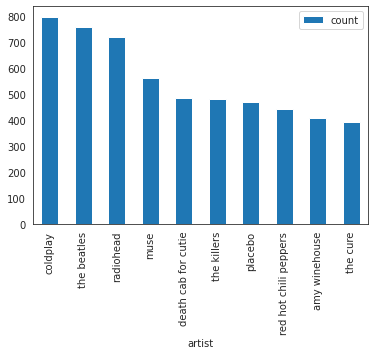

In [ ]:
#exploratory data analysis to check the most frequently played artists by female

female = SparkDF.filter(SparkDF.sex == 'f')
a = female.groupby(['artist']).count().sort(desc('count')).toPandas()
print(a.head(10))

plt.figure(figsize=(50,40))
a.head(10).plot(kind="bar", x="artist", y="count")
plt.show()

Use Apriori or FPGrowth algorithm to identify the listening preference of users and recommend
new artists to the user. Identify and report an optimal combination of support and confidence
using lift. Apply visualisation to report your results

In [ ]:
#using FPGrowth alogorithm and training a model with the set minSupport and minConfidence

#The first step is to create a set of association rules in order to determine the optimal thresholds for support and confidence.
#This is because if we set these values too low, then the algorithm will take longer to execute and will return a lot of rules.
#The approach is to try different values of support and confidence and see graphically how many rules are generated for each combination.

#We will use confidenceLevel to iterate through the fp_growth algorithm as the confidence values
confidenceLevel = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)

#We will use supportLevel as our support values to use for our models / 0.05% / 0.075% / 0.1% / 0.5%
supportLevel = (0.005, 0.0075, 0.01, 0.05)

In [ ]:
#Create the first model with a support value of 0.05%

#create empty variables to hold the associationRules.count() value
rules_005percent = []

#Using a for-loop to iterate through the confidenceLevel Values
for i in range(len(confidenceLevel)):
  fp_growth005percent = FPGrowth(itemsCol = 'artist', minSupport=supportLevel[0], minConfidence=confidenceLevel[i])
  model005percent = fp_growth005percent.fit(GroupedDF)
  rules_005percent.append(model005percent.associationRules.count())

print(rules_005percent)

[11593, 6879, 3853, 1950, 793, 191, 17]


In [ ]:
#creating the second model with a support value of 0.075%

rules_0075percent = []

for i in range(len(confidenceLevel)):
  fp_growth0075percent = FPGrowth(itemsCol = 'artist', minSupport=supportLevel[1], minConfidence=confidenceLevel[i])
  model0075percent = fp_growth0075percent.fit(GroupedDF)
  rules_0075percent.append(model0075percent.associationRules.count())

print(rules_0075percent)

[4086, 2191, 1136, 533, 176, 35, 1]


In [ ]:
#creating the third model with a support value of 0.1%

rules_01percent = []

for i in range(len(confidenceLevel)):
  fp_growth01percent = FPGrowth(itemsCol = 'artist', minSupport=supportLevel[2], minConfidence=confidenceLevel[i])
  model01percent = fp_growth01percent.fit(GroupedDF)
  rules_01percent.append(model01percent.associationRules.count())

print(rules_01percent)

[1903, 1088, 498, 211, 50, 7, 0]


In [ ]:
#creating the fourth model with a support value of 0.5%

rules_05percent = []

for i in range(len(confidenceLevel)):
  fp_growth05percent = FPGrowth(itemsCol = 'artist', minSupport=supportLevel[3], minConfidence=confidenceLevel[i])
  model05percent = fp_growth05percent.fit(GroupedDF)
  rules_05percent.append(model05percent.associationRules.count())

print(rules_05percent)

[4, 4, 4, 0, 0, 0, 0]


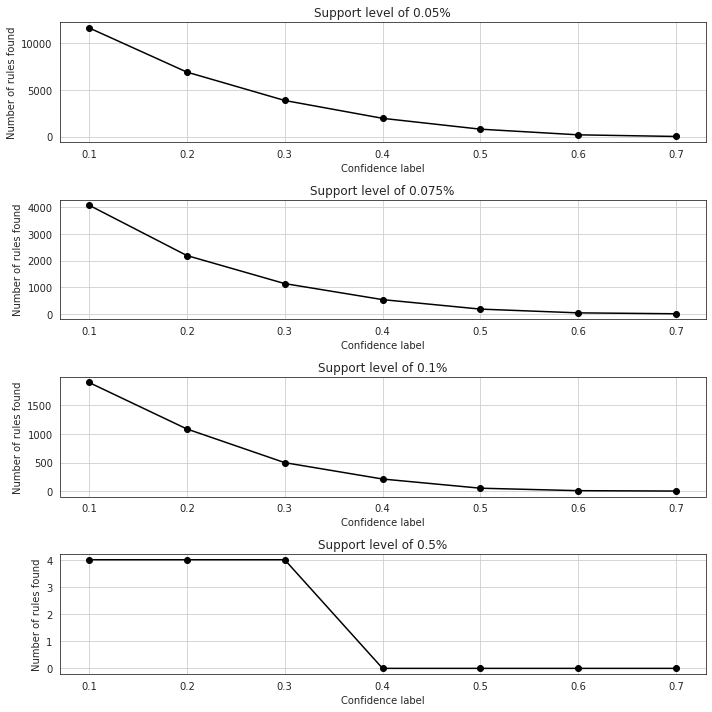

In [ ]:
#plot line chart for model 1, 2, 3 and 4

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10, 10))
ax1.plot(confidenceLevel, rules_005percent, color='black', marker='o')
ax1.set_title('Support level of 0.05%')
ax1.set_xlabel('Confidence label')
ax1.set_ylabel('Number of rules found')
ax1.grid(True)

ax2.plot(confidenceLevel, rules_0075percent, color='black', marker='o')
ax2.set_title('Support level of 0.075%')
ax2.set_xlabel('Confidence label')
ax2.set_ylabel('Number of rules found')
ax2.grid(True)

ax3.plot(confidenceLevel, rules_01percent, color='black', marker='o')
ax3.set_title('Support level of 0.1%')
ax3.set_xlabel('Confidence label')
ax3.set_ylabel('Number of rules found')
ax3.grid(True)

ax4.plot(confidenceLevel, rules_05percent, color='black', marker='o')
ax4.set_title('Support level of 0.5%')
ax4.set_xlabel('Confidence label')
ax4.set_ylabel('Number of rules found')
ax4.grid(True)

fig.tight_layout()
plt.show()

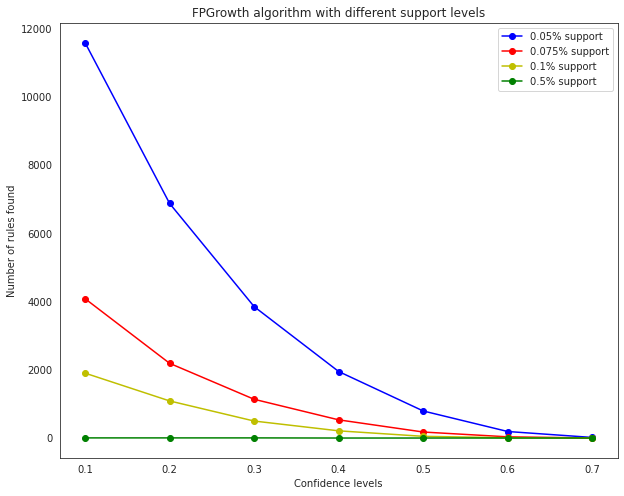

In [ ]:
#Merge the plots above
fig=plt.figure(figsize=(10,8))
fig.show()
ax=fig.add_subplot(111)

ax.plot(confidenceLevel, rules_005percent, c='b',marker="o",label='0.05% support')
ax.plot(confidenceLevel, rules_0075percent,c='r',marker="o",label='0.075% support')
ax.plot(confidenceLevel, rules_01percent, c='y',marker="o",label='0.1% support')
ax.plot(confidenceLevel, rules_05percent, c='g',marker="o",label='0.5% support')

ax.set_title('FPGrowth algorithm with different support levels')
ax.set_xlabel('Confidence levels')
ax.set_ylabel('Number of rules found')

plt.legend(loc=1)
plt.draw()

In [ ]:
#From the visualisations above, we will pick the suitable minsupport and minconfidence values
fp_growth = FPGrowth(itemsCol = 'artist', minSupport=0.0075, minConfidence=0.4)
model = fp_growth.fit(GroupedDF)

print(model.freqItemsets.count())
print(model.associationRules.count())

3084
533


In [ ]:
model.associationRules.sort(desc('lift')).show()

+--------------------+----------------+-------------------+------------------+--------------------+
|          antecedent|      consequent|         confidence|              lift|             support|
+--------------------+----------------+-------------------+------------------+--------------------+
|[the pussycat dolls]|       [beyoncé]|0.46296296296296297|15.570503238664674|0.008333333333333333|
|               [nas]|         [jay-z]| 0.4262734584450402|14.052971157528798|              0.0106|
|[the pussycat dolls]|       [rihanna]| 0.5777777777777777|13.415892672858615|              0.0104|
|        [digitalism]|       [justice]| 0.4485294117647059|13.166225394267295|0.008133333333333333|
|[the pussycat dolls]|     [lady gaga]|0.42592592592592593| 12.60135875520491|0.007666666666666666|
|       [chris brown]|       [rihanna]| 0.5113122171945701|11.872574702660296|0.007533333333333334|
|       [leona lewis]|       [rihanna]| 0.5044642857142857|11.713567005749667|0.007533333333333334|


In [ ]:
model.transform(GroupedDF).drop("artist", "sex", "country").sort('user').show(truncate=False)

+----+-------------------------------------------------------------------------+
|user|prediction                                                               |
+----+-------------------------------------------------------------------------+
|1   |[coldplay, the beatles, iron maiden, metallica]                          |
|3   |[the beatles, death cab for cutie]                                       |
|4   |[death cab for cutie, radiohead, coldplay, the beatles]                  |
|5   |[in flames]                                                              |
|6   |[coldplay, radiohead, led zeppelin, the beatles]                         |
|7   |[the beatles, coldplay, metallica]                                       |
|9   |[metallica]                                                              |
|12  |[metallica, radiohead]                                                   |
|13  |[the beatles, radiohead]                                                 |
|14  |[the beatles, radiohea

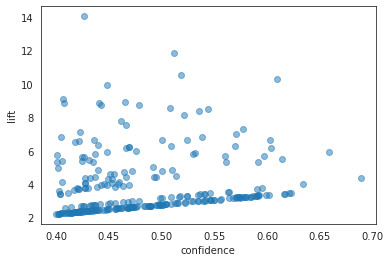

In [ ]:
#Sampling the rules generated from the model using pandas
associationRules = model.associationRules.toPandas()
assRules = associationRules.sample(frac=0.5, random_state=0)
supportRules = assRules.loc[:,'confidence']
liftRules = assRules.loc[:,'lift']

plt.scatter(supportRules, liftRules,   alpha=0.5, marker="o")
plt.xlabel('confidence')
plt.ylabel('lift')
plt.show()

#data skewed to the lower end of the support values as the data is so big